<a href="http://landlab.github.io"><img style="float: left" src="https://raw.githubusercontent.com/landlab/tutorials/master/landlab_header.png"></a>


# Using the Landlab SpeciesEvolver component

<hr>
<small> For instructions on how to run an interactive iPython notebook, click here: <a href="https://github.com/landlab/tutorials/blob/master/README.md">https://github.com/landlab/tutorials/blob/master/README.md</a></small><br>
<small>For more Landlab tutorials, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a></small>
<hr>

In this tutorial we will:
* Introduce species into a Landlab model.
* Set the zones in which the species operate.
* Evolve a landscape and the species over time.
* Explore SpeciesEvolver output data structures.

The configuration of the model in this tutorial loosely follows the fault throw experiment in Lyons et al., in preperation for Earth Surface Dynamics.

## Macroevolution processes built into species

The evolution of the base species is driven by these processes:
* dispersal: geographic range expansion
* speciation: lineage splitting
* extinction: lineage termination

Import modules and set the environment to show plots inline in this notebook.

In [1]:
from landlab import CLOSED_BOUNDARY, FIXED_VALUE_BOUNDARY
from landlab.components import (SpeciesEvolver, FastscapeEroder, FlowRouter,
                                LinearDiffuser)
from landlab.components.species_macroevolution import plot, Species, Zone
from landlab.io import read_esri_ascii
from landlab.plot import imshow_grid
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Prepare the grid and components of the model.

Load a model grid that has steady state topography. The top and bottom boundaries are set to open.

In [2]:
(mg, z) = read_esri_ascii('model_grid_steady_state_elevation.txt')
mg.at_node['topographic__elevation'] = z
mg.set_status_at_node_on_edges(right=CLOSED_BOUNDARY, top=FIXED_VALUE_BOUNDARY,
                               left=CLOSED_BOUNDARY,
                               bottom=FIXED_VALUE_BOUNDARY)

Initialize components. SpeciesEvolver requires only one parameter, a model grid.

In [3]:
fr = FlowRouter(mg)
sp = FastscapeEroder(mg, K_sp=10e-5, m_sp=0.5, n_sp=1.0)
lf = LinearDiffuser(mg, linear_diffusivity=0.0001)
se = SpeciesEvolver(mg)

## Prepare SpeciesEvolver objects

Species and zones are the two object types central to SpeciesEvolver.

### Zones

Zones are portions of a model grid. A Species object exists throughout a zone.

At each timestep, the spatial intersection of the zones at the prior time and current time are identified and typed. For example, a zone in the prior time intersects two zones in the current time. This zone path is typed one-to-many.

Macroevolutionary processes are carried out by the intersection of zones over time. The connectivity of zones in SpeciesEvolver are called 'paths', and the relationship of zones is described by the path type. Not all combinations of none, one, and many are considered at the time of this tutorial. All none-to-n and some many-to-n are not considered. 

<img style="float: left;" src="images/zone__one_to_none.png"> &nbsp; zone<sub>*t*</sub>: a zone in time, *t*.<br>

<img style="float: left;" src="images/zone__later_time.png"> &nbsp; zone<sub>*t*+1</sub>: a zone in the time following *t*.

<center>path type</center> | <center>graphical<br>represention</center> | <center>zone temporal connectivity</center> | <center>macroevolution implications</center>
--- | --- | --- | ---
one-to-none | ![](images/zone__one_to_none.png) | zone<sub>*t*</sub> does not intersect a zone in *t*+1. | The species in the zone of the earlier time will go extinct. 
one-to-one | ![](images/zone__one_to_one.png) | zone<sub>*t*</sub> intersects zone<sub>*t*+1</sub>. | The species in the zone of the earlier time will relocate to the zone of the later time.
one-to-many | ![](images/zone__one_to_many.png) | zone<sub>*t*</sub> intersects multiple zones in *t*+1. | The species in the zone of the earlier time disperses across the multiple zones in the later time. The species in the zones of the later time are geographical disconnected, thus speciation occurs.
many-to-one | ![](images/zone__many_to_one.png) | Multiple zones in *t* intersect zone<sub>*t*+1</sub>. | Species density increases locally.
many-to-many | ![](images/zone__many_to_many.png) | Multiple zones in *t* intersect multiple zones in *t*+1. | Species distribution shifts. Speciation occurs where the zone of a species at *t* intersects more than one zone at *t*+1.

### Species

The model domain is populated with species by the user.

The rules of macroevolution are programmed into species. Behind the scenes, zone paths are the conditions evaluated by the macroevolution rules. The outcome of the rules given the zone paths are described in the zone table above. For example, a one-to-many path:

![](images/zone_path__one_to_many.png)

The base species class 

Users may develop species with different behaviors and macroevolution rules.





Populate SpeciesEvolver zones with species.


In [4]:
fr.run_one_step()

min_stream_area = 1e6
zones = Zone.get_zones_with_area_threshold(mg, min_stream_area)
for zone in zones:
    new_species = Species(0, zone)
    se.introduce_species(new_species, 0)

## Initiate a fault

Define the fault.

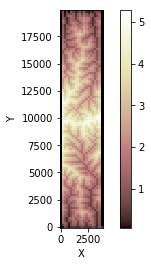

In [5]:
grid_width = mg.number_of_node_columns * mg.dx
x_of_fault = grid_width * 0.5
core_mask = mg.node_is_core()
upthown_nodes = mg.x_of_node >= x_of_fault
upthown_block_mask = np.all([core_mask, upthown_nodes], 0)

imshow_grid(mg, 'topographic__elevation')

Uplift the nodes of the upthrown block by 20 m.

In [6]:
z[upthown_block_mask] += 20

## Model species evolution

First, set model time step and uplift parameters.

SpeciesEvolver runs every 10 timesteps of the other components.

In [7]:
dt = 1000
total_time = int(1e5)
nt = int(total_time // dt)

dt_se = 10 * dt

uplift_rate = 7e-5
uplift_per_step = uplift_rate * dt

Run model. The ```run_one_step``` function of SpeciesEvolver takes the new zones of the time step.

This code block may take a couple minutes to run.

In [8]:
for time_i in range(nt):
    # Uniformly uplift.
    z[mg.core_nodes] += uplift_per_step

    # Increment earth surface process components.
    fr.run_one_step()
    sp.run_one_step(dt)
    lf.run_one_step(dt)

    elapsed_time = dt * (time_i + 1)

    if elapsed_time % dt_se == 0:
        # Run SpeciesEvolver with updated zones.
        zones = Zone.get_zones_with_area_threshold(mg, min_stream_area)
        se.run_one_step(elapsed_time, zones)

## Plot results



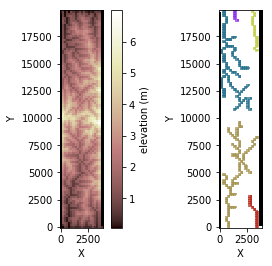

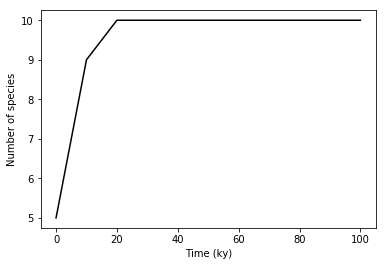

In [9]:
plt.subplot(1, 2, 1)
imshow_grid(mg, 'topographic__elevation', colorbar_label='elevation (m)')

plt.subplot(1, 2, 2)
plot.imshow_zones(mg, zones)

plot.number_of_species(se.record, se.species)

## Species identifiers and phylogenetic trees

Species identifiers are automatically generated. They are stored as tuples in species objects. The first element of the identifier tuple is the clade name, and the second element is the species number. For example, the first species of clade A is 0, so the identifier is (A, 0) and the tenth species of this clade is (A, 9).

### Clade name

A clade is a group of species that share a common ancestor. Species may share multiple common ancestors, so clades can be defined differently in the same tree. The clade(s) of this example tree can be defined in multiple ways:

![](images/clade_definitions.png)

In SpeciesEvolver, clades are defined by the root node for the purpose of assigning species identifiers. The species at the root node is:
* the least recent common ancestor of all species in the tree, and
* typically introduced to a SpeciesEvolver model using the ```introduce_species``` function.

The clades of the first 26 species are named alphabetically from A to Z. The alphabet is repeated for subsequent species following this schema:

<center>clade sequence</center> | <center>clade name</center>
--- | ---
1–26 | A–Z
27–52 | AA–AZ
53–78 | BA–BZ
... | ...
703–728 | AAA–AAZ
729–754 | ABA–ABZ
... | ...

### Species number

Species are numbered sequently by clade beginning with 0.

In the example tree below, species A0 produced 4 child species. Only one species, B0 exists in clade B because child species were not produced by B0.

![](images/species_number.png)

E ---------
  children number  subclades  x_max  x_min      y
0      NaN      4        2.0  100.0   20.0  0.500
1      NaN      3        2.0  100.0   20.0  1.000
2      NaN      1        0.0  100.0   10.0  1.500
3      NaN      2        0.0   10.0   10.0  0.750
4      NaN      0       -1.0    0.0    0.0  1.125
D ---------
  children number  subclades  x_max  x_min    y
0      NaN      0       -1.0  100.0    0.0  2.0
C ---------
  children number  subclades  x_max  x_min    y
0      NaN      0       -1.0  100.0    0.0  2.5
B ---------
  children number  subclades  x_max  x_min     y
0      NaN      4        0.0  100.0   10.0  3.00
1      NaN      3        0.0  100.0   10.0  3.50
2      NaN      2        0.0  100.0   10.0  4.00
3      NaN      1        0.0  100.0   10.0  4.50
4      NaN      0       -1.0    0.0    0.0  3.75
A ---------
  children number  subclades  x_max  x_min    y
0      NaN      0       -1.0  100.0    0.0  5.0


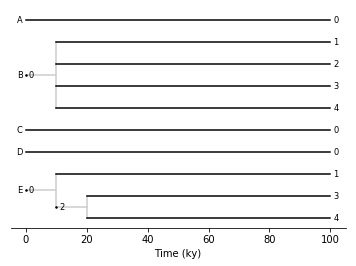

In [10]:
from landlab.components.species_macroevolution import plot

plot.tree(se.species)

## DataFrames

Data are stored in Pandas DataFrames.

In [11]:
se.species

,clade,species,time_appeared,latest_time,subtype,object
0,A,0,0,100000,base,<Species at 0x1c19ad9860>
1,B,0,0,0,base,<Species at 0x1c19abfd30>
2,C,0,0,100000,base,<Species at 0x1c19ad9f28>
3,D,0,0,100000,base,<Species at 0x1c19ad9438>
4,E,0,0,0,base,<Species at 0x1c19ad96a0>
5,B,2,10000,100000,base,<Species at 0x1c25163828>
6,B,3,10000,100000,base,<Species at 0x1c25163048>
7,B,1,10000,100000,base,<Species at 0x1c25163710>
8,B,4,10000,100000,base,<Species at 0x1c25163940>
9,E,2,10000,10000,base,<Species at 0x1c25163978>


In [12]:
se.zones

,time_appeared,latest_time,subtype,object
0,0,30000,base,<Zone at 0x1c19ad9978>
1,0,100000,base,<Zone at 0x1c19ad9a58>
2,0,100000,base,<Zone at 0x1c19ad9b38>
3,0,100000,base,<Zone at 0x1c19ad9c18>
4,0,100000,base,<Zone at 0x1c19ad9cf8>
5,10000,100000,base,<Zone at 0x1c2512f208>
6,10000,10000,base,<Zone at 0x1c2512f438>
7,10000,30000,base,<Zone at 0x1c2512f668>
8,10000,50000,base,<Zone at 0x1c2512f080>
9,10000,10000,base,<Zone at 0x1c2512f898>


In [13]:
se.zone_paths

,time,origin,destinations,path_type
0,10000,<Zone at 0x1c19ad9978>,[<Zone at 0x1c19ad9978>],one-to-one
1,10000,<Zone at 0x1c19ad9a58>,"[<Zone at 0x1c2512f208>, <Zone at 0x1c19ad9a58...",one-to-many
2,10000,<Zone at 0x1c19ad9b38>,[<Zone at 0x1c19ad9b38>],one-to-one
3,10000,<Zone at 0x1c19ad9c18>,[<Zone at 0x1c19ad9c18>],one-to-one
4,10000,<Zone at 0x1c19ad9cf8>,"[<Zone at 0x1c2512f668>, <Zone at 0x1c19ad9cf8>]",one-to-many
5,10000,NaN,[<Zone at 0x1c2512f080>],one-to-many
6,10000,NaN,[<Zone at 0x1c2512f208>],one-to-many
7,10000,NaN,[<Zone at 0x1c19ad9a58>],one-to-many
8,10000,NaN,[<Zone at 0x1c2512f438>],one-to-many
9,10000,NaN,[<Zone at 0x1c2512f550>],one-to-many


### Record DataFrames

Instances of SpeciesEvolver, species, and zones each have DataFrames called ```record```. Rows are data stored at each time the model is ran.

Examine the SpeciesEvolver record.

In [14]:
se.record

,time,number_of_captures,sum_of_area_captured
0,0.0,NaN,NaN
1,10000.0,6.0,240000.0
2,20000.0,2.0,80000.0
3,30000.0,0.0,0.0
4,40000.0,0.0,0.0
5,50000.0,0.0,0.0
6,60000.0,0.0,0.0
7,70000.0,0.0,0.0
8,80000.0,0.0,0.0
9,90000.0,0.0,0.0


Examine the record of a species.

In [15]:
s = be.species.iloc[0].object
s.record

NameError: name 'be' is not defined

Examine the record of a zone.

In [ ]:
z = be.zones.iloc[0].object
z.record

### Click here for more <a href="https://github.com/landlab/landlab/wiki/Tutorials">Landlab tutorials</a>